## Audi Prices

**The objective of the analysis is to compare different regression algorithms to predict in the best way the selling price of Audi cars, given different variables**

*Importing packages*

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Train-test split
from sklearn.preprocessing import MinMaxScaler # Scaling data
from sklearn.feature_selection import SelectKBest, f_regression # N° variables
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore') # Ignoring sklearn warnings

sns.set()

In [2]:
dataset = pd.read_csv('Audi.csv')
dataset.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [3]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
year,10668.0,2017.100675,2.167494,1997.0,2016.00,2017.0,2019.0,2020.0
price,10668.0,22896.685039,11714.841888,1490.0,15130.75,20200.0,27990.0,145000.0
mileage,10668.0,24827.244001,23505.257205,1.0,5968.75,19000.0,36464.5,323000.0
tax,10668.0,126.011436,67.170294,0.0,125.00,145.0,145.0,580.0
mpg,10668.0,50.770022,12.949782,18.9,40.90,49.6,58.9,188.3
engineSize,10668.0,1.930709,0.602957,0.0,1.50,2.0,2.0,6.3


**The dataset has:**

- 5 numerical columns: Price, mileage, tax, mpg and EngineSize.
- 3 categorical columns: Model, transmission and FuelType
- 1 date column: year

**Getting to know the data**

*How are the cars distributed by the registration year?*

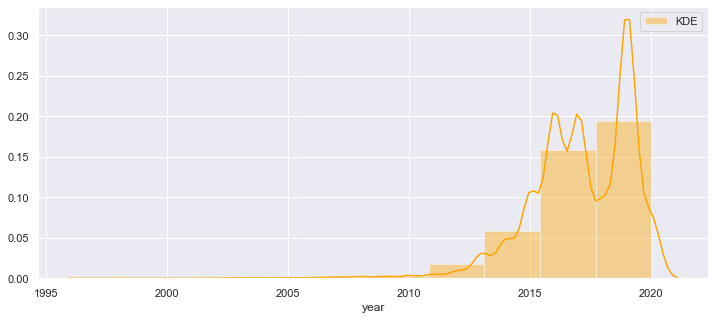

In [4]:
sns.distplot(dataset['year'], bins = 10, color = 'orange', label = 'KDE')
plt.legend()
plt.gcf().set_size_inches(12, 5)

*How many models are in the set?*
*How many types of transmission?*
*How many types of fuel?*

In [5]:
print(dataset.model.unique())
print('--'* 50)

print(dataset.transmission.unique())
print('--'* 50)

print(dataset.fuelType.unique())
print('--'* 50)

[' A1' ' A6' ' A4' ' A3' ' Q3' ' Q5' ' A5' ' S4' ' Q2' ' A7' ' TT' ' Q7'
 ' RS6' ' RS3' ' A8' ' Q8' ' RS4' ' RS5' ' R8' ' SQ5' ' S8' ' SQ7' ' S3'
 ' S5' ' A2' ' RS7']
----------------------------------------------------------------------------------------------------
['Manual' 'Automatic' 'Semi-Auto']
----------------------------------------------------------------------------------------------------
['Petrol' 'Diesel' 'Hybrid']
----------------------------------------------------------------------------------------------------


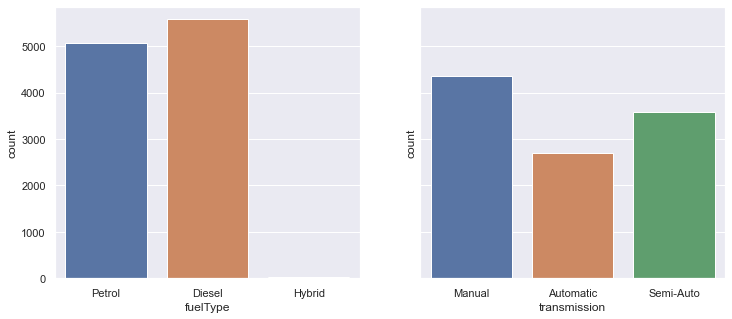

In [6]:
fig, ax =plt.subplots(1,2, sharey = True)
plt.gcf().set_size_inches(12, 5)
sns.countplot(dataset['fuelType'], ax = ax[0])
sns.countplot(dataset['transmission'], ax = ax[1])
plt.show()

**So there are just 3 types of transmission and 3 types of fuel, it seems there are many models.**

In [7]:
Model = pd.DataFrame(dataset['model'].value_counts())

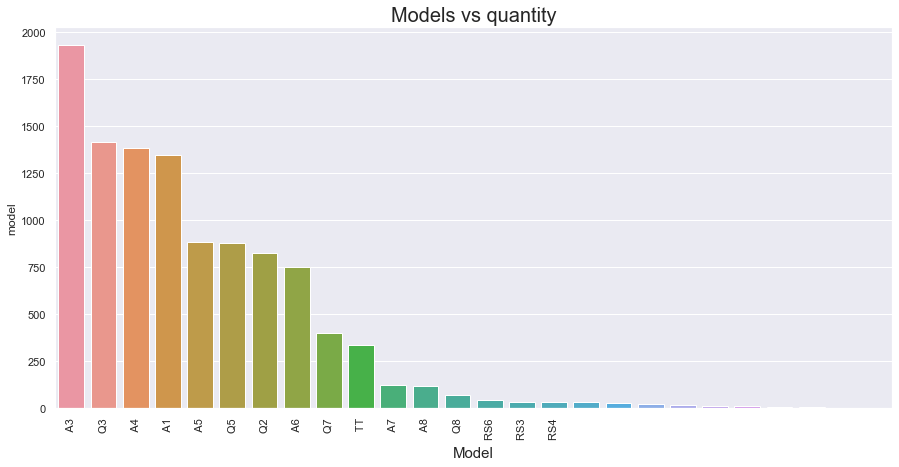

In [8]:
sns.barplot(x = Model.index, y = Model['model'])

labels = Model.index.tolist()
plt.gcf().set_size_inches(15, 7)

plt.title('Models vs quantity', fontsize = 20)
plt.xlabel('Model', fontsize = 15)

plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] , labels = labels, rotation = 'vertical')
plt.show()

*Price analysis*

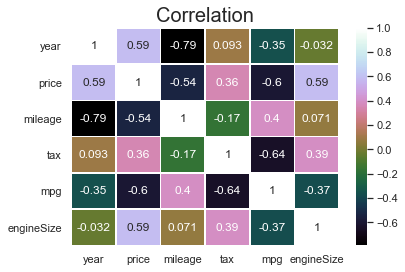

In [9]:
sns.heatmap(dataset.corr(), annot = True, linewidths=.5, cmap='cubehelix')
plt.title('Correlation', fontsize = 20)
plt.show()

**All the variables except 'tax' are strong predictors for the car price. Also, there is surely a correlation between the model, fuel type and transmission, so later on we will do some OHE for those variables** 

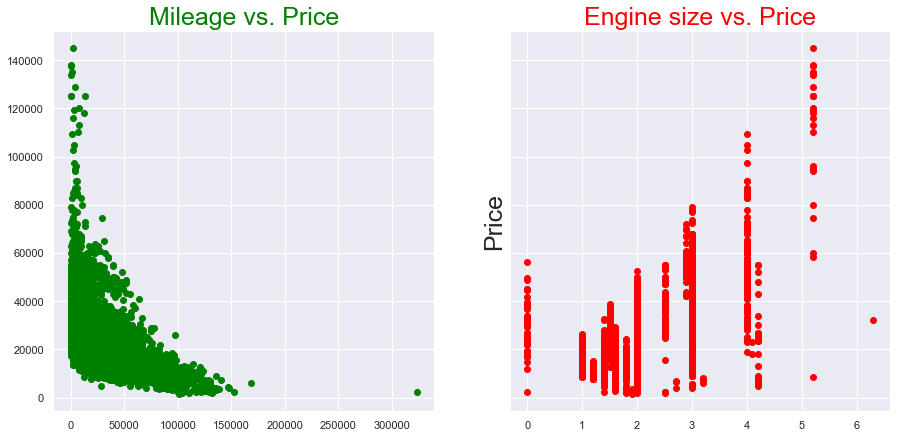

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

plt.gcf().set_size_inches(15, 7)
ax1.scatter(dataset.mileage, dataset.price, c = 'green')
ax1.set_title('Mileage vs. Price', c = 'green', fontsize = 25)
ax2.scatter(dataset.engineSize, dataset.price, c='red')
ax2.set_title('Engine size vs. Price', c ='red', fontsize = 25)

plt.ylabel('Price', fontsize = 25)

plt.show()

**There are clear correlations:**

- The price goes down as the car has more mileage (it might be really worn out).
- The price goes up as the engine size gets bigger. There are some cars that do not follow this tendency, so we should assume that the different models have an impact on the price.

*Preparing the data for the model*

In [11]:
dataset2 = dataset.copy()
dataset2 = dataset2[['model','year','transmission','mileage','fuelType','tax','mpg','engineSize','price']]
dataset2.head(3)

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,A1,2017,Manual,15735,Petrol,150,55.4,1.4,12500
1,A6,2016,Automatic,36203,Diesel,20,64.2,2.0,16500
2,A1,2016,Manual,29946,Petrol,30,55.4,1.4,11000


**OHE for model, transmission and fuel type**

In [12]:
data_audi_D = pd.get_dummies(dataset2)
data_audi_D.head(3)

,year,mileage,tax,mpg,engineSize,price,model_ A1,model_ A2,model_ A3,model_ A4,...,model_ S8,model_ SQ5,model_ SQ7,model_ TT,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,2017,15735,150,55.4,1.4,12500,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2016,36203,20,64.2,2.0,16500,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,2016,29946,30,55.4,1.4,11000,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


**To avoid multicollinearity issues, I'll drop one column for model, one for transmission, and one from fuel type.**

In [13]:
data_audi_D = data_audi_D.drop(['model_ A1', 'transmission_Automatic', 'fuelType_Diesel'], axis=1)

**Scaling the data**

In [14]:
MinMaxScaler = MinMaxScaler() 
data_audi_D_Scaled = MinMaxScaler.fit_transform(data_audi_D)
data_audi_D_Scaled = pd.DataFrame(data_audi_D_Scaled, columns = data_audi_D.columns)
data_audi_D_Scaled.head(3)

,year,mileage,tax,mpg,engineSize,price,model_ A2,model_ A3,model_ A4,model_ A5,...,model_ S4,model_ S5,model_ S8,model_ SQ5,model_ SQ7,model_ TT,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
0,0.869565,0.048712,0.258621,0.215466,0.222222,0.076719,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.826087,0.112081,0.034483,0.267414,0.317460,0.104592,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.826087,0.092709,0.051724,0.215466,0.222222,0.066267,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


**Separating variables**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_audi_D_Scaled.drop(columns = ['price']),
                                                    data_audi_D_Scaled[['price']],
                                                    test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8534, 34)
(8534, 1)
(2134, 34)
(2134, 1)


*There are 35 independent variables*

**Selecting the best features for the regression with SelectKBest, f_regression**

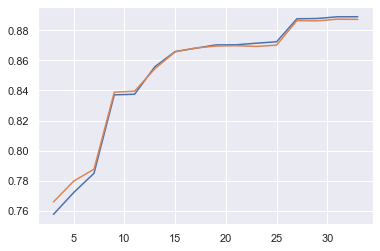

In [16]:
column_names = data_audi_D_Scaled.drop(columns = ['price']).columns

no_of_features = []
r_squared_train = []
r_squared_test = []

for k in range(3, 35, 2): # From 3 to 35 variables (every single one)
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))
    
sns.lineplot(x = no_of_features, y = r_squared_train, legend = 'full')
sns.lineplot(x = no_of_features, y = r_squared_test, legend = 'full')
plt.show()

*We get a steable curve from 27 variables on, so that is the amount of variables I'm using*

In [17]:
# Doing the same as above but only with k = 27

selector = SelectKBest(f_regression, k = 27)
X_train_transformed = selector.fit_transform(X_train, y_train)
X_test_transformed = selector.transform(X_test)
column_names[selector.get_support()]

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A2', 'model_ A3',
       'model_ A4', 'model_ A5', 'model_ A7', 'model_ A8', 'model_ Q5',
       'model_ Q7', 'model_ Q8', 'model_ R8', 'model_ RS3', 'model_ RS4',
       'model_ RS5', 'model_ RS6', 'model_ S4', 'model_ SQ5', 'model_ SQ7',
       'model_ TT', 'transmission_Manual', 'transmission_Semi-Auto',
       'fuelType_Hybrid', 'fuelType_Petrol'],
      dtype='object')

**Linear Modeling**

In [18]:
def regression_model(model):
    """
    Will fit the regression model passed and will return the regressor object and the score
    """
    regressor = model
    regressor.fit(X_train_transformed, y_train)
    score = regressor.score(X_test_transformed, y_test) # R2
    return regressor, score

In [19]:
model_performance = pd.DataFrame(columns = ["Features", "Model", "Score"])

models_to_evaluate = [LinearRegression(), Ridge(), Lasso(), SVR(), RandomForestRegressor(), MLPRegressor()]

for model in models_to_evaluate:
    regressor, score = regression_model(model)
    model_performance = model_performance.append({"Features": "Linear","Model": model, "Score": score}, ignore_index=True)

model_performance

,Features,Model,Score
0,Linear,LinearRegression(),0.886374
1,Linear,Ridge(),0.887164
2,Linear,Lasso(),-0.000107
3,Linear,SVR(),0.563099
4,Linear,"(DecisionTreeRegressor(max_features='auto', ra...",0.955293
5,Linear,MLPRegressor(),0.914253


**Polynomial Modelling**

*Transforming X variable*

In [20]:
poly = PolynomialFeatures()
X_train_transformed_poly = poly.fit_transform(X_train)
X_test_transformed_poly = poly.transform(X_test)

print(X_train_transformed_poly.shape)

(8534, 630)


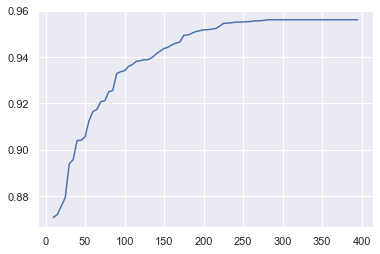

In [21]:
no_of_features = []
r_squared = []

for k in range(10, 400, 5): # Seeing what happens up to 400 variables
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train_transformed_poly, y_train)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared.append(regressor.score(X_train_transformed, y_train))
        
sns.lineplot(x = no_of_features, y = r_squared)
plt.show()

*We get a steable curve from 250 variables on, so that is the amount of variables I'm using*

In [22]:
selector = SelectKBest(f_regression, k = 250)

X_train_transformed = selector.fit_transform(X_train_transformed_poly, y_train)
X_test_transformed = selector.transform(X_test_transformed_poly)

models_to_evaluate = [LinearRegression(), Ridge(), Lasso(), SVR(kernel = 'poly'), RandomForestRegressor(), MLPRegressor()]

for model in models_to_evaluate:
    regressor, score = regression_model(model)
    model_performance = model_performance.append({"Features": "Polynomial","Model": model, "Score": score}, ignore_index=True)

model_performance

,Features,Model,Score
0,Linear,LinearRegression(),0.886374
1,Linear,Ridge(),0.887164
2,Linear,Lasso(),-0.000107
3,Linear,SVR(),0.563099
4,Linear,"(DecisionTreeRegressor(max_features='auto', ra...",0.955293
5,Linear,MLPRegressor(),0.914253
6,Polynomial,LinearRegression(),0.171610
7,Polynomial,Ridge(),0.937809
8,Polynomial,Lasso(),-0.000107
9,Polynomial,SVR(kernel='poly'),0.594293


**The maximum score is 0.96 with RandomForest polynomial regression**

**Predictions with RandomForest polynomial regression**

In [23]:
regressor_final = RandomForestRegressor(n_estimators = 100, random_state = 42)
regressor.fit(X_train_transformed_poly, y_train)

y_pred = regressor.predict(X_test_transformed_poly)

In [24]:
y_test = y_test.reset_index() # To join the Dataframes


y_pred_df = pd.DataFrame({'Price_prediction': y_pred.flatten()})

In [25]:
Comparison = y_test.join(y_pred_df) 
Comparison = Comparison.drop(['index'], axis=1)
Comparison.head()

,price,Price_prediction
0,0.094126,0.088979
1,0.142568,0.168417
2,0.191624,0.196869
3,0.167229,0.165845
4,0.205282,0.201049


In [26]:
Fifty_comparison = Comparison.head(50)

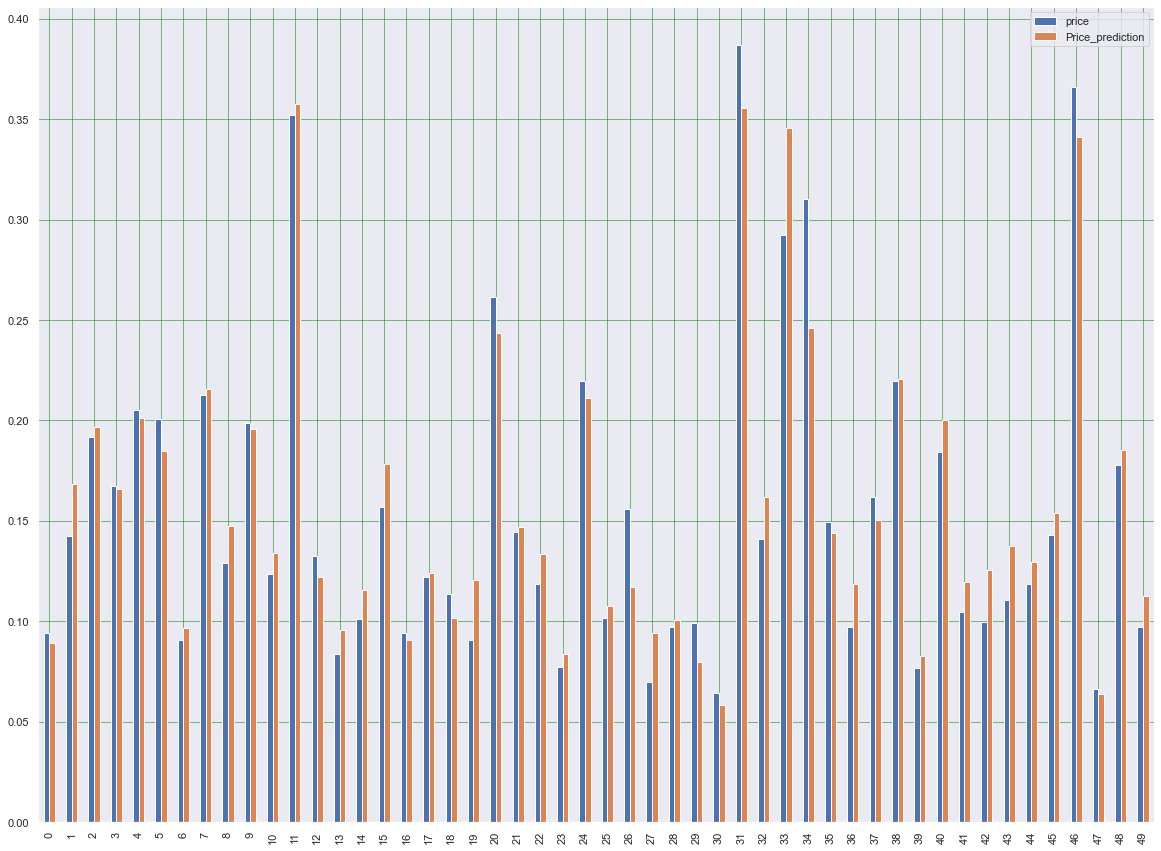

In [27]:
Fifty_comparison.plot(kind = 'bar', figsize=(20,15))
plt.grid(which = 'both', linestyle = '-', linewidth = '0.5', color = 'green')
plt.show()

**Métricas**

In [28]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test.drop(['index'], axis = 1), y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test.drop(['index'], axis = 1), y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test.drop(['index'], axis = 1), y_pred)))
print('R2:', metrics.r2_score(y_test.drop(['index'], axis = 1), y_pred))
Adj_r2 = 1 - (1 - metrics.r2_score(y_test.drop(['index'], axis = 1), y_pred)) * (10668 - 1) / (10668 - 250 - 1)
print('R2 adjusted', Adj_r2)

Mean Absolute Error: 0.014295593434424837
Mean Squared Error: 0.00039640983834472233
Root Mean Squared Error: 0.019910043655017994
R2: 0.9405883775982228
R2 adjusted 0.9391625442872461
